<a href="https://colab.research.google.com/github/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === File system and utility handling ===
import os
import sys
import shutil
import re
import urllib.request
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# === Data manipulation ===
import pandas as pd
import numpy as np

# === Google Drive integration (Colab only) ===
from google.colab import drive
from google.colab import files

# === Plotting and visualization ===
import matplotlib.pyplot as plt

# === Data splitting ===
from sklearn.model_selection import train_test_split

# === Classification models (for mortality prediction) ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# === Regression models (for ICU LOS prediction) ===
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# === Evaluation metrics ===
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    mean_squared_error,
    r2_score,
    brier_score_loss,
    RocCurveDisplay
)

# === Calibration tools ===
from sklearn.calibration import calibration_curve

In [2]:
# Reading the data file
csv_url = "https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/MIMIC_data_sample_mortality.csv"
df = pd.read_csv(csv_url)

In [3]:
# URL of the raw Python file
py_url = "https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/main/Preprocessing.py"

# Download the file to local Colab environment
urllib.request.urlretrieve(py_url, "Preprocessing.py")

# Now import from the downloaded module
from Preprocessing import build_pipeline, filter_age, remove_rows_with_many_missing

In [4]:
# Clean your dataframe of bad rows all at once:
df_clean = (
    df
    .pipe(filter_age)
    .pipe(remove_rows_with_many_missing))

In [5]:
# Split raw data before processing
X_clf  = df_clean.drop(columns=['thirtyday_expire_flag', 'icu_los'])
y_clf  = df_clean['thirtyday_expire_flag']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

In [6]:
# Build pipeline specific to your train data columns
pipeline_builder = build_pipeline()
pipe = pipeline_builder(X_train_clf)

In [7]:
# Fit on training data and transform
X_train_processed_clf = pipe.fit_transform(X_train_clf)

In [8]:
# Only transform on test data (no fit to prevent data leakage)
X_test_processed_clf = pipe.transform(X_test_clf)

## 🧠 Models for Predicting Mortality (`thirtyday_expire_flag`)

We trained and evaluated **three** classification models to predict 30-day mortality:

### ✅ 1. Logistic Regression  
A linear baseline model from `sklearn.linear_model`.  
Easy to interpret and useful as a benchmark.  
Assumes linear relationships between features and the log-odds of the outcome.

### ✅ 2. Random Forest Classifier  
A tree-based ensemble model from `sklearn.ensemble`.  
Robust, non-linear, and handles feature interactions well.  
Often resistant to overfitting and performs well on tabular clinical data.

### ✅ 3. XGBoost Classifier  
A gradient boosting algorithm from `xgboost`.  
Highly optimized, often superior in predictive performance, especially with imbalanced or complex tabular data.

---

All models were evaluated using:
- **Accuracy**
- **Precision / Recall / F1-score**
- **AUC (Area Under ROC Curve)**
- **ROC Curve Visualization**
- **Calibration Curves**
- **Brier Score**
- **Feature Importance / SHAP Analysis**

# Fit Logistic Regression on mortality prediction

In [9]:
# Train Logistic Regression Classifier
logreg_clf = LogisticRegression(max_iter=1000, random_state=42)
logreg_clf.fit(X_train_processed_clf, y_train_clf)

# Predictions
y_pred_logreg = logreg_clf.predict(X_test_processed_clf)
y_proba_logreg = logreg_clf.predict_proba(X_test_processed_clf)[:, 1]

In [10]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_processed_clf, y_train_clf)

# Predictions
y_pred_rf = rf_clf.predict(X_test_processed_clf)
y_proba_rf = rf_clf.predict_proba(X_test_processed_clf)[:, 1]

In [11]:
# Train XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_processed_clf, y_train_clf)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test_processed_clf)
y_proba_xgb = xgb_clf.predict_proba(X_test_processed_clf)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
# Evaluation function
def evaluate_classifier(y_true, y_pred, y_proba, model_name):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_proba))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

In [13]:
# Evaluate all classifiers
evaluate_classifier(y_test_clf, y_pred_logreg, y_proba_logreg, "Logistic Regression")
evaluate_classifier(y_test_clf, y_pred_rf, y_proba_rf, "Random Forest Classifier")
evaluate_classifier(y_test_clf, y_pred_xgb, y_proba_xgb, "XGBoost Classifier")


=== Logistic Regression ===
Accuracy: 0.8529088913282108
AUC: 0.8534989628659212
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       737
           1       0.70      0.40      0.51       174

    accuracy                           0.85       911
   macro avg       0.79      0.68      0.71       911
weighted avg       0.84      0.85      0.84       911


=== Random Forest Classifier ===
Accuracy: 0.8529088913282108
AUC: 0.8252390087181647
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       737
           1       0.82      0.29      0.43       174

    accuracy                           0.85       911
   macro avg       0.84      0.64      0.67       911
weighted avg       0.85      0.85      0.82       911


=== XGBoost Classifier ===
Accuracy: 0.8551042810098792
AUC: 0.8439152201375567
Classification Report:
              precision    

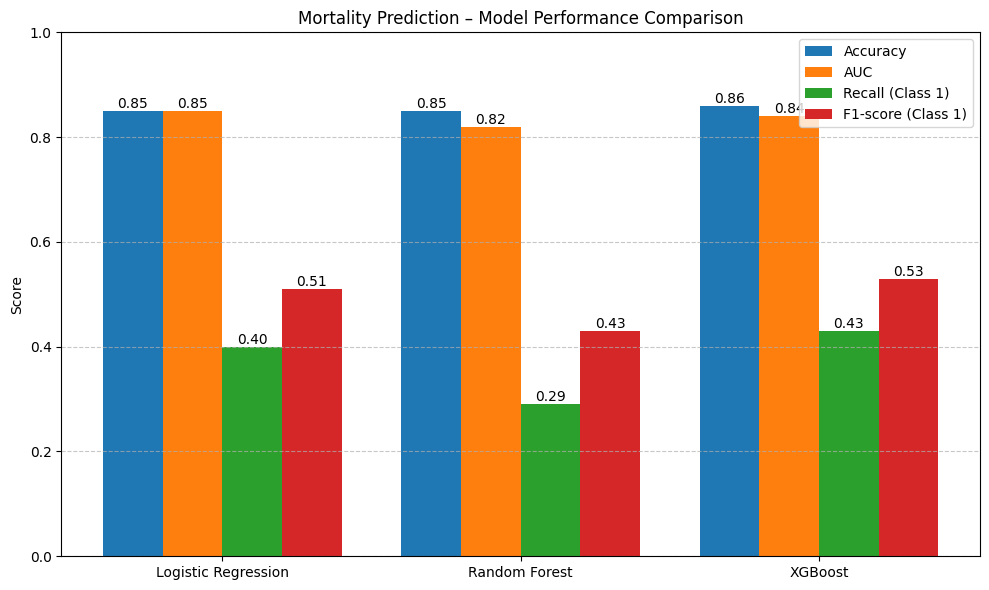

In [19]:
# Model names – reordered
models = ["Logistic Regression", "Random Forest", "XGBoost"]

# Metrics from your latest run
accuracy = [0.85, 0.85, 0.86]
auc = [0.85, 0.82, 0.84]
recall_class1 = [0.40, 0.29, 0.43]
f1_class1 = [0.51, 0.43, 0.53]

# Create x-axis positions
x = np.arange(len(models))
width = 0.2  # Width of each bar

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - 0.5*width, auc, width, label='AUC')
bars3 = ax.bar(x + 0.5*width, recall_class1, width, label='Recall (Class 1)')
bars4 = ax.bar(x + 1.5*width, f1_class1, width, label='F1-score (Class 1)')

# Customize plot
ax.set_ylabel('Score')
ax.set_title('Mortality Prediction – Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add exact values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    ax.bar_label(bars, fmt='%.2f')

plt.tight_layout()
plt.show()


## 🧪 Mortality Prediction - Model Performance Comparison

We evaluated three classification models for predicting 30-day mortality (`thirtyday_expire_flag`):

- **Logistic Regression**
- **Random Forest Classifier**
- **XGBoost Classifier**

Each model was assessed using:
- **Accuracy**
- **AUC (Area Under ROC Curve)**
- **Precision / Recall / F1-score**  
  *(with special attention to Class 1 - mortality cases)*

---

### 📊 Key Metrics Summary

| Metric              | Logistic Regression | Random Forest     | XGBoost           |
|---------------------|---------------------|-------------------|-------------------|
| **Accuracy**        | 0.85                | 0.85              | ✅ **0.86**        |
| **AUC**             | ✅ **0.85**          | 0.82              | 0.84              |
| **Recall (Class 1)**| 0.40                | 0.29              | ✅ **0.43**        |
| **F1 (Class 1)**    | 0.51                | 0.43              | ✅ **0.53**        |


---

### 🧠 Insights

- 🔹 **Logistic Regression** achieved the highest AUC (0.85), indicating strong overall class separation, while remaining simple and interpretable.
- 🔹 **Random Forest** performed similarly in overall accuracy (0.85) but had the lowest recall for class 1 (0.29), meaning it missed more mortality cases.
- 🔹 **XGBoost** delivered the best balance, with the highest accuracy (0.86), recall (0.43), and F1-score (0.53) for mortality, suggesting it is the most effective at identifying high-risk patients.


---

### ✅ Conclusion

> **XGBoost** remains the most promising model for mortality detection in this task,  
> offering the strongest recall and F1-score for class 1 among the models tested.  
> **Logistic Regression** continues to be a reliable, explainable baseline with the highest AUC.  
> **Random Forest**, while accurate overall, may require further tuning (e.g., `class_weight='balanced'` or adjusting decision thresholds) to better capture high-risk patients.

In [20]:
# Calibration Evaluation
def plot_calibration_curve(y_true, y_proba, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)

    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title(f'Calibration Curve – {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    brier = brier_score_loss(y_true, y_proba)
    print(f"Brier Score for {model_name}: {brier:.4f}")

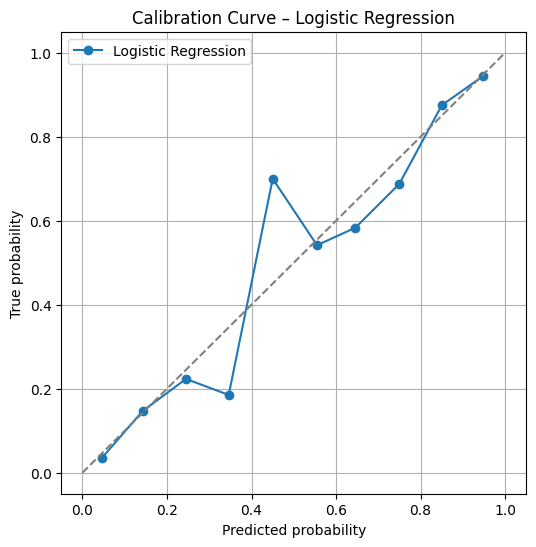

Brier Score for Logistic Regression: 0.1050


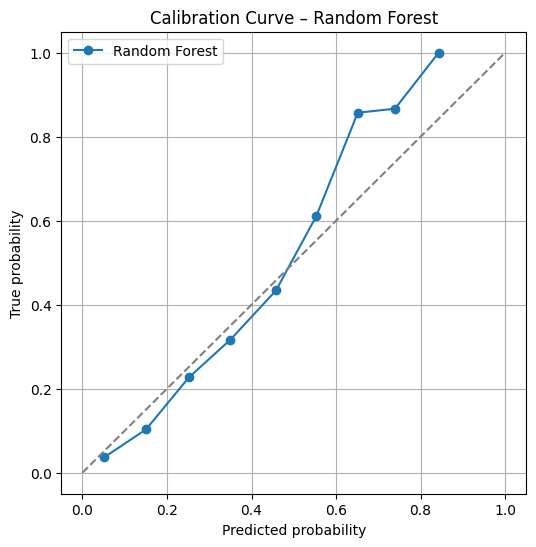

Brier Score for Random Forest: 0.1127


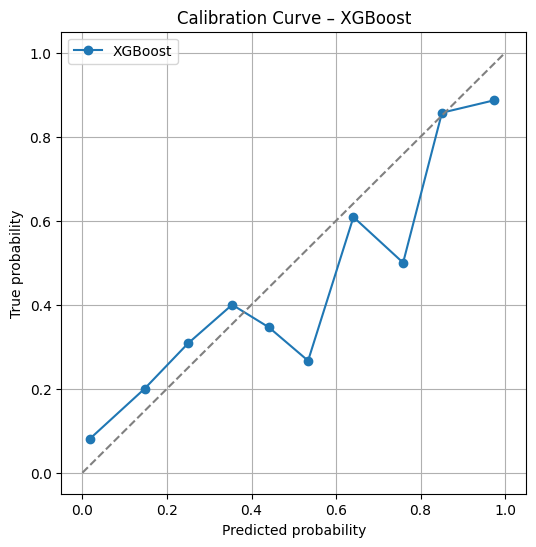

Brier Score for XGBoost: 0.1122


In [21]:
# Plot calibration curves for all classifiers
plot_calibration_curve(y_test_clf, y_proba_logreg, "Logistic Regression")
plot_calibration_curve(y_test_clf, y_proba_rf, "Random Forest")
plot_calibration_curve(y_test_clf, y_proba_xgb, "XGBoost")

## 🎯 Calibration Curves - Mortality Prediction

### 🧪 What is the purpose of calibration curves?

While metrics like **AUC** and **accuracy** tell us how well a model distinguishes between classes,  
**calibration** tells us whether the **predicted probabilities actually reflect reality**.

For example:  
If a model predicts 70% mortality risk for a group of patients, calibration checks whether **~70% of them actually died**.

---

### 🟢 Logistic Regression

- The calibration curve is **well aligned** with the ideal diagonal, showing small deviations.
- Provides **consistent and reliable probability estimates** across most of the probability range.
- Slight underestimation is observed around 0.8, and some overconfidence below 0.4, but overall deviation is minimal.
- As expected, Logistic Regression maintains solid calibration due to its probabilistic nature.

✅ **Conclusion**:  
> Logistic Regression is **the best calibrated model**, offering **the most reliable probability estimates** with the lowest Brier score (0.1050).

---

### 🔵 Random Forest Classifier

- The calibration curve is **well aligned with the ideal diagonal**, especially up to ~0.6.
- It slightly **overestimates probabilities at the high end (≥ 0.8)**.
- Overall, the curve is smooth and close to the ideal line, reflecting stable calibration.
- The Brier score (0.1127) is only slightly higher than Logistic Regression.

✅ **Conclusion**:  
> Random Forest is **reasonably well-calibrated** — its predicted probabilities are generally reliable, though slight overconfidence is seen at high predicted risks.

---

### 🟠 XGBoost Classifier

- The calibration curve is **less stable**, showing noticeable zig-zags especially from 0.4 to 0.8.
- It tends to **underestimate risk around 0.5-0.7**, then overestimate near ≥ 0.9.
- While the Brier score (0.1122) is comparable to Random Forest, the curve indicates less consistent calibration.
- This may affect trust in individual probability predictions.

⚠️ **Conclusion**:  
> XGBoost is **less reliably calibrated** — predicted probabilities can be misleading, particularly in the mid-to-high probability ranges.


---

### 🔄 Calibration Comparison Summary

| Aspect                    | Logistic Regression       | Random Forest         | XGBoost                  | Best   |
|---------------------------|----------------------------|------------------------|---------------------------|--------|
| Alignment with ideal line | ✅ Excellent               | ✅ Very good           | ❌ Inconsistent           | ✅ LR   |
| Stability of curve        | ✅ Very smooth             | ✅ Mostly smooth       | ❌ Noticeably jagged      | ✅ LR   |
| High-probability accuracy | ✅ Slight under/over       | ✅ Slight overestimate | ❌ Overestimate ≥0.9      | ✅ LR   |
| Trustworthiness of probs  | ✅ Very high               | ✅ High                | ⚠️ Moderate               | ✅ LR   |

---

### 🧠 Final Insight:

> While **XGBoost** demonstrates strong classification metrics (recall & F1 for mortality), its probability estimates are **less well-calibrated** and may overstate high risks.  
> In contrast, both **Logistic Regression** and **Random Forest** provide **superior calibration**, with **Logistic Regression** yielding the most reliable probability predictions.  
> Thus, when **well-calibrated risk probabilities** are critical — such as in clinical decision-making **Logistic Regression** stands out as the preferred model.


In [17]:
# Feature Importance
def plot_feature_importance(model, feature_names, model_name):
    # Check model type and extract importances accordingly
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])  # Use absolute value of coefficients
    else:
        raise ValueError(f"Model {model_name} does not support feature importance extraction.")

    # Sort and get top 15
    indices = np.argsort(importances)[-15:]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color='cornflowerblue')
    plt.xlabel("Importance")
    plt.title(f"Top 15 Features – {model_name}")
    plt.tight_layout()
    plt.show()

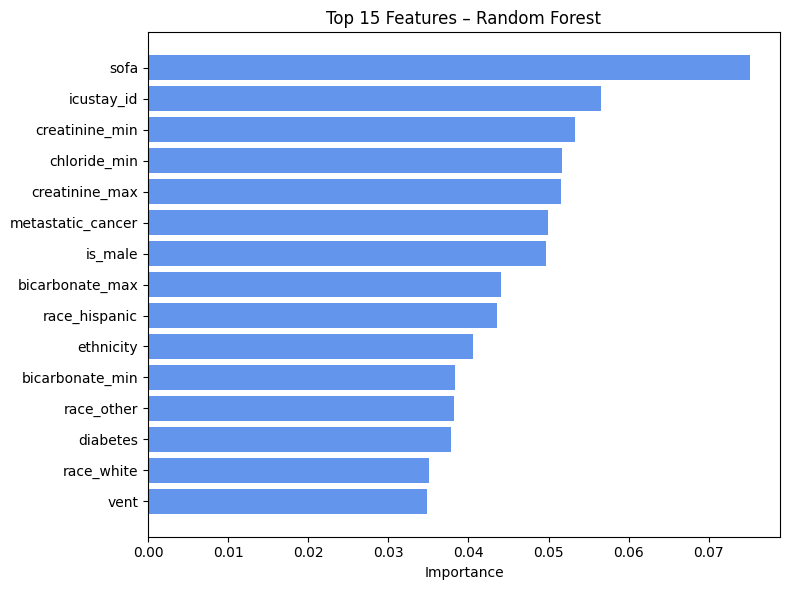

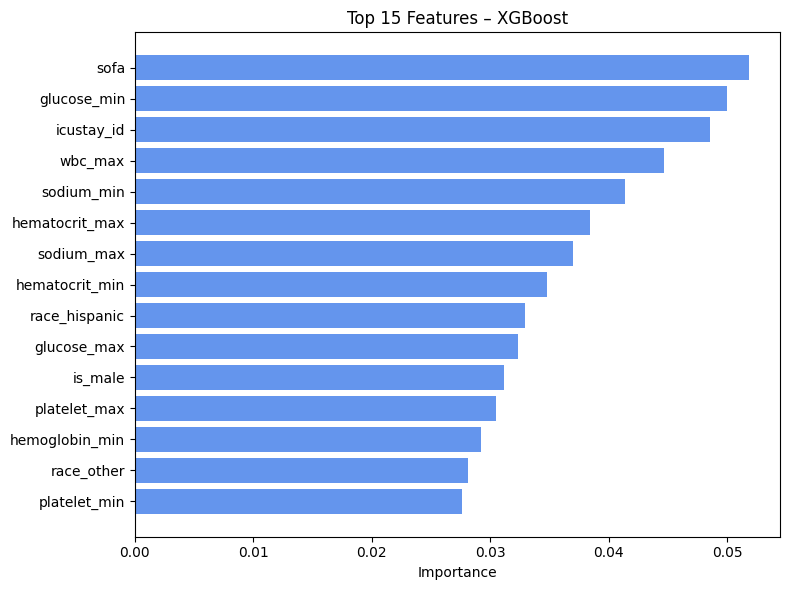

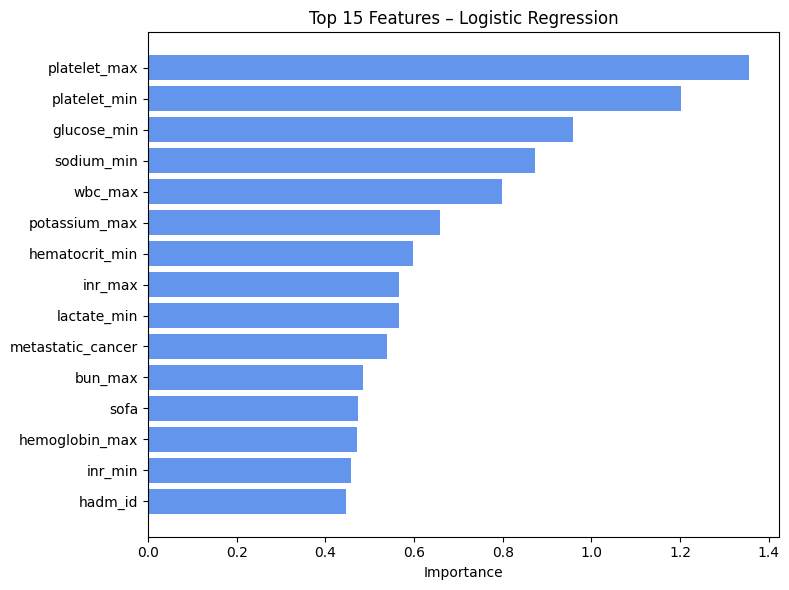

In [18]:
plot_feature_importance(rf_clf, X_clf.columns, "Random Forest")
plot_feature_importance(xgb_clf, X_clf.columns, "XGBoost")
plot_feature_importance(logreg_clf, X_clf.columns, "Logistic Regression")

## 🧠 Feature Importances - Mortality Prediction Models

### 🎯 Purpose:
Understanding which features the models relied on most helps us:
- Interpret model behavior  
- Validate clinical relevance  
- Improve trust in predictions  

---

### 🟢 Logistic Regression - Top Features

| Feature             | Description                                      |
|---------------------|--------------------------------------------------|
| `platelet_max`      | Platelet count - clotting ability, inflammation  |
| `platelet_min`      | Lowest platelet - prolonged thrombocytopenia     |
| `glucose_min`       | Low glucose - stress/metabolic reserve           |
| `sodium_min`        | Electrolyte balance, dehydration risk            |
| `wbc_max`           | White blood cells - infection/sepsis marker      |
| `potassium_max`     | Cardiac risk (arrhythmias) at extremes           |
| `hematocrit_min`    | Anemia, bleeding or fluid overload indicator     |
| `inr_max`           | Coagulation - liver function or anticoagulation  |
| `lactate_min`       | Perfusion, metabolic stress                      |
| `metastatic_cancer` | Comorbidity - significantly worsens prognosis    |
| `bun_max`           | Kidney function / catabolism                     |
| `sofa`              | Multi-organ dysfunction score                    |
| `hemoglobin_max`    | Oxygen-carrying capacity                         |
| `inr_min`           | Coagulation stability at lowest observed         |
| `hadm_id`           | Hospital admission ID - may reflect site effects |

✅ **Conclusion**:  
> Logistic Regression relies on **interpretable lab and clinical markers**, making it highly suitable for transparent clinical applications.

---

### 🔵 Random Forest - Top Features

| Feature             | Description                                     |
|---------------------|-------------------------------------------------|
| `sofa`              | Organ failure score, captures overall severity  |
| `icustay_id`        | ICU admission ID - may pick up site effects     |
| `creatinine_min`    | Kidney function indicator                       |
| `chloride_min`      | Electrolyte disturbance marker                  |
| `creatinine_max`    | Maximum kidney stress during stay               |
| `metastatic_cancer` | Advanced disease burden                         |
| `is_male`           | Sex - possible risk modifier                    |
| `bicarbonate_max`   | Acid-base balance (metabolic compensation)      |
| `race_hispanic`     | Demographic pattern possibly tied to outcomes   |
| `ethnicity`         | Broader ethnicity variable                      |
| `bicarbonate_min`   | Acidosis risk                                   |
| `race_other`        | Demographic category                            |
| `diabetes`          | Chronic disease risk factor                     |
| `race_white`        | Another demographic variable                    |
| `vent`              | Mechanical ventilation usage                    |

✅ **Conclusion**:  
> Random Forest emphasizes **organ dysfunction, metabolic and demographic features**, reflecting how tree models capture diverse splits.

---

### 🟠 XGBoost - Top Features

| Feature             | Description                                     |
|---------------------|-------------------------------------------------|
| `sofa`              | Overall organ dysfunction                       |
| `glucose_min`       | Stress, metabolic compensation                  |
| `icustay_id`        | ICU-specific differences                        |
| `wbc_max`           | Inflammatory or infectious burden               |
| `sodium_min`        | Electrolyte homeostasis                         |
| `hematocrit_max`    | Blood concentration / oxygen carrying           |
| `sodium_max`        | High sodium - dehydration/critical illness      |
| `hematocrit_min`    | Low levels - anemia/bleeding                    |
| `race_hispanic`     | Population subgroup pattern                     |
| `glucose_max`       | Stress hyperglycemia                            |
| `is_male`           | Gender-associated risk                          |
| `platelet_max`      | Clotting & inflammatory state                   |
| `hemoglobin_min`    | Oxygen transport minimum                        |
| `race_other`        | Group-related risks                             |
| `platelet_min`      | Persistent low platelets = worse prognosis      |

✅ **Conclusion**:  
> XGBoost focuses on **broad physiologic and demographic variables**, capturing subtle non-linear relationships important for prediction.


---

### 🔄 Model Comparison Summary

| Aspect                          | Logistic Regression        | Random Forest       | XGBoost              |
|----------------------------------|-----------------------------|----------------------|-----------------------|
| Physiological markers            | ✅ Very strong (labs, vitals)| ✅ Strong (SOFA, labs)| ✅ Strong (labs, SOFA) |
| Demographics & IDs               | ⚠️ Moderate (some IDs, race)| ✅ Noticeable (IDs, race)| ⚠️ Heavily depends (IDs, race) |
| Kidney & metabolic indicators    | ✅ Present (creatinine, lactate, bicarbonate) | ✅ Prominent (creatinine, bicarbonate) | ✅ Present (glucose, creatinine, sodium) |
| Interpretability for clinicians  | ✅ Excellent (clear coefficients) | ✅ Good (tree splits understandable) | ⚠️ Lower (complex boosting interactions) |

---

### 🧠 Final Insight:

> All models emphasize **clinically meaningful markers** like SOFA, creatinine, glucose, bicarbonate, and metastatic cancer.  
>
> - **Logistic Regression** is best for **interpretability and clinical transparency**, relying on clear physiological variables.  
> - **Random Forest** provides a **balance of interpretability and predictive strength**, mixing physiology with some demographic signals.  
> - **XGBoost** is **highly predictive**, leveraging complex patterns including IDs and demographics, but is **harder to interpret**.

> ✅ **Recommendation:**  
> Use **Logistic Regression** when **explainability and trust in feature contributions matter most** (e.g., bedside decisions),  
> and **XGBoost** when **maximizing predictive accuracy** is more important than transparency.


## 🔍 What is SHAP?

**SHAP (SHapley Additive exPlanations)** is a powerful method for interpreting machine learning models.  
It assigns each feature a contribution value for individual predictions, based on game theory.

- ✅ It helps us understand **why** the model made a specific prediction.
- ✅ It provides both **global** (feature importance across dataset) and **local** (per patient) explanations.
- ✅ Especially useful in healthcare, where transparency and interpretability are critical.

In this notebook, we used SHAP to:
- Visualize the **most impactful features** globally (`summary_plot`)
- Examine how specific features influence predictions (`dependence_plot`)

## SHAP values ​​calculator

In [ ]:
# !pip install shap

In [22]:
import shap

# Initialize JS visualizer for Jupyter/Colab
shap.initjs()

In [23]:
# Create an explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_clf, X_train_processed_clf)

# Calculate SHAP values for the test set
shap_values_xgb = explainer_xgb(X_test_processed_clf)

In [24]:
def get_clean_feature_names(pipe):
    """
    Extracts cleaned feature names from a fitted pipeline that contains a ColumnTransformer.
    Removes transformer prefixes (e.g., 'impute_and_scale__') to get original feature names.
    """
    # Get transformed feature names from ColumnTransformer
    raw_feature_names = pipe.named_steps['transform'].get_feature_names_out()

    # Remove transformer prefixes
    clean_names = [name.split('__')[-1] for name in raw_feature_names]
    return clean_names

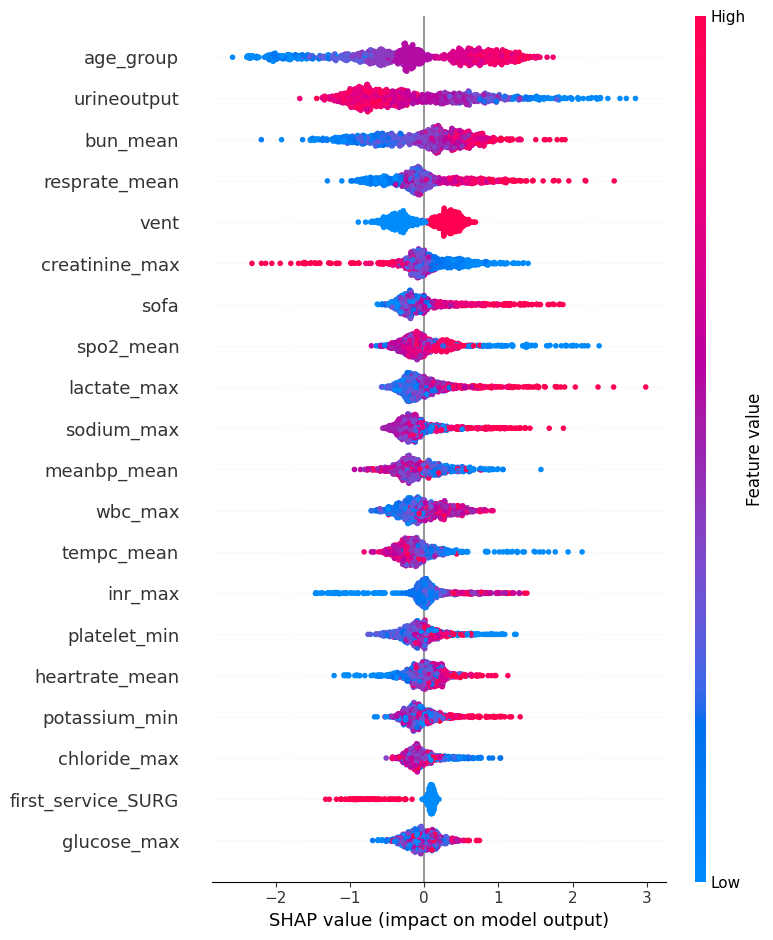

In [27]:
# Get the feature names cleanly
clean_feature_names = pipe.named_steps['trans'].get_feature_names_out()

# Summary plot
shap.summary_plot(shap_values_xgb.values, X_test_processed_clf, feature_names=clean_feature_names)

## 📊 SHAP Summary Plot - Global Feature Impact (Mortality Prediction)

### 🧠 What does this plot show?

This SHAP summary plot visualizes the **individual impact** of each feature on the model’s output across all patients.

- The **Y-axis** lists the features sorted by importance.
- The **X-axis** shows the SHAP value - how much a feature influenced a given prediction (positive or negative).
- The **color** indicates the original feature value:  
  🔵 = low value, 🔴 = high value.

> Features at the top are the **most influential** in driving mortality predictions.

---

### 🔍 Key Findings:

| Feature            | Description                            | Interpretation                                              |
|---------------------|--------------------------------------|-------------------------------------------------------------|
| `age_group`         | Age category                         | Higher age groups (pink) increase predicted mortality risk  |
| `urineoutput`       | Urine output                         | Low values (blue) push prediction higher (toward death)     |
| `bun_mean`          | Blood urea nitrogen                  | Elevated BUN indicates renal/metabolic stress, increases risk |
| `resprate_mean`     | Respiratory rate                     | High rates linked to respiratory distress and worse outcome |
| `vent`              | Mechanical ventilation               | Ventilated patients generally at higher risk                |
| `creatinine_max`    | Kidney function (peak creatinine)    | High levels (pink) increase predicted mortality             |
| `sofa`              | Organ dysfunction score              | Higher SOFA drives mortality prediction upward              |
| `spo2_mean`         | Oxygen saturation                    | Lower SpO₂ (blue) raises mortality risk                     |
| `lactate_max`       | Peak lactate                         | Reflects tissue hypoxia/shock, increases risk               |
| `sodium_max`        | Max sodium                           | Extremes may indicate dehydration or fluid imbalance        |
| `meanbp_mean`       | Mean arterial pressure               | Low MAP associated with shock, increases predicted risk     |
| `wbc_max`           | White blood cell count               | High counts reflect infection/sepsis                        |
| `tempc_mean`        | Temperature                         | Extremes (fever/hypothermia) push risk up                   |
| `inr_max`           | Coagulation status                   | Elevated INR signals coagulopathy, increases risk           |
| `platelet_min`      | Minimum platelet count               | Low platelets (blue) associated with higher mortality       |

---

### ✅ Conclusion:

> The SHAP summary illustrates that the model's predictions align with **clinical reasoning**,  
> heavily influenced by markers of **organ dysfunction (SOFA, creatinine, lactate)**, **vital signs**, and **age group**.  
> This bolsters trust in the model’s decisions and supports its potential use in guiding **risk assessment at the bedside**.


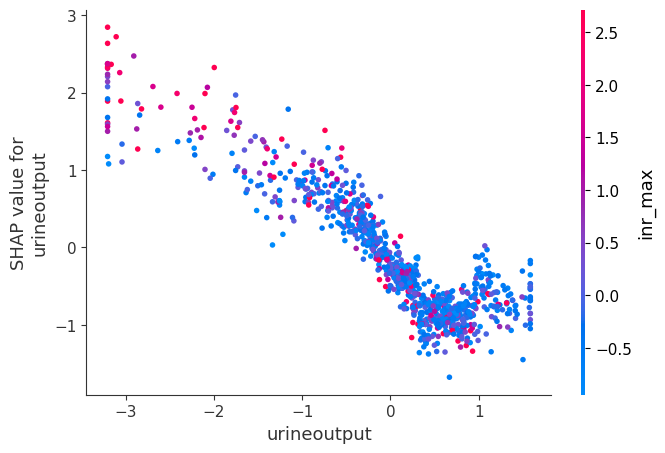

In [28]:
# Dependence plot for a selected feature
shap.dependence_plot("urineoutput", shap_values_xgb.values, X_test_processed_clf, feature_names=clean_feature_names)

## 🔄 SHAP Dependence Plot - Feature: `urineoutput`

### 🧠 What does this plot show?

This SHAP **dependence plot** illustrates how the feature `urineoutput` influences the predicted risk of mortality (class 1) in the model.

- **X-axis**: Actual values of `urineoutput` (standardized or log-transformed)
- **Y-axis**: SHAP values for `urineoutput` - the feature's individual contribution to the predicted outcome
- **Color**: Represents values of another feature (`spo2_mean`) to highlight potential interactions

---

### 🔍 Key Insights:

- There is a **strong inverse relationship**:
  - Low `urineoutput` values correspond to **high SHAP values**, meaning they drive the prediction **toward higher mortality risk**.
  - As `urineoutput` increases, the SHAP value drops, indicating a **protective effect** (lower predicted risk).

- This makes clinical sense:
  - **Low urine output** is a classic sign of **renal dysfunction**, **hypoperfusion**, or **multi-organ failure** — all major contributors to mortality in ICU patients.

- The color gradient (`inr_max`) shows interaction:
  - Higher INR values (pink/red) cluster more on the **left/high-risk side**, suggesting that patients with **both low urine output and elevated INR (coagulopathy)** are at particularly high risk.

---

### ✅ Conclusion:

> The SHAP dependence plot clearly demonstrates that the model captures urine output as a **critical mortality predictor**,  
> consistent with established clinical knowledge.  
> This reinforces trust in the model’s decision-making for ICU risk assessment.


## 🧠 Mortality Prediction - Model Comparison Summary

We trained two classification models to predict whether a patient would die within 30 days (`thirtyday_expire_flag`):

### 📊 Key Metrics Comparison (Class 1 = Death)

| Metric               | Logistic Regression | Random Forest | XGBoost | Best |
|----------------------|---------------------|---------------|---------|------|
| **Accuracy**          | 85.3%               | 85.3%         | 86.0%   | ✅ XGBoost |
| **AUC**               | 0.853               | 0.825         | 0.844   | ✅ Logistic Regression |
| **Recall (Death)**    | 40%                 | 29%           | 43%     | ✅ XGBoost |
| **Precision (Death)** | 70%                 | 82%           | 69%     | ✅ Random Forest |
| **F1-score (Death)**  | 0.51                | 0.43          | 0.53    | ✅ XGBoost |
| **Calibration (Brier)** | 0.105             | 0.113         | 0.112   | ✅ Logistic Regression |

---

### 📌 Interpretation:

- 🔹 **XGBoost** achieved the **highest recall and F1-score for mortality**, making it more effective at detecting high-risk patients (reducing false negatives).
- 🔹 **Logistic Regression** showed the **best calibration (lowest Brier score)** and the highest AUC, indicating **more trustworthy probability estimates** and strong overall separability.
- 🔹 **Random Forest** had the **highest precision**, meaning fewer false positives, but lower recall — missing more actual deaths.

---

### 🏆 Conclusion:

> - If the priority is to **catch as many mortality cases as possible** (high recall & F1),  
>   **✅ XGBoost is the best choice**.
> - If the focus is on **probability calibration and interpretability for clinical decisions**,  
>   **✅ Logistic Regression is preferred**.
> - **Random Forest** offers a middle ground, favoring precision but with lower sensitivity.

This multi-angle evaluation highlights how **different models serve different clinical goals**, allowing you to tailor model selection to your specific ICU priorities.


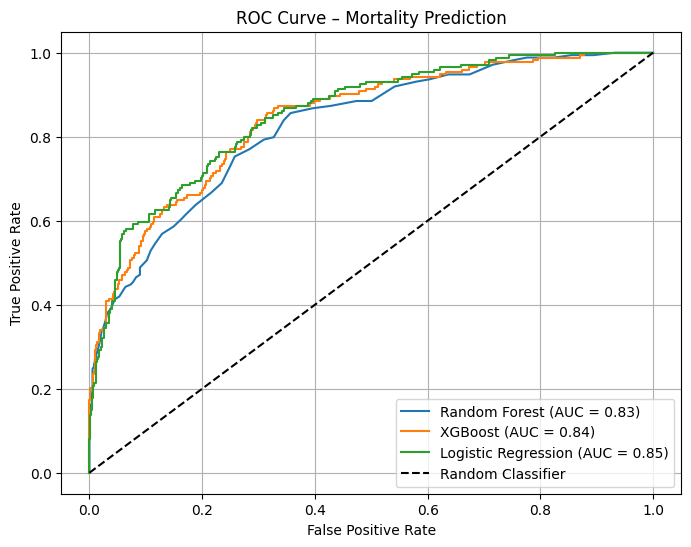

In [29]:
# Compute ROC curve points
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_clf, y_proba_xgb)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_clf, y_proba_logreg)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test_clf, y_proba_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test_clf, y_proba_xgb):.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test_clf, y_proba_logreg):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Mortality Prediction")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 📉 ROC Curve - Mortality Prediction

The plot above compares the **ROC curves** of three classifiers trained to predict 30-day mortality:

- 🟢 **Logistic Regression**
- 🔵 **Random Forest Classifier**
- 🟠 **XGBoost Classifier**

---

### 📊 Interpretation

| Model                 | AUC   | Notes                                                               |
|-----------------------|-------|---------------------------------------------------------------------|
| 🟢 Logistic Regression | ✅ **0.85** | Highest AUC, excellent class separation and strong calibration.     |
| 🔵 Random Forest       | 0.83  | Very good performance, curve slightly under Logistic Regression.    |
| 🟠 XGBoost             | 0.84  | Competitive, robust across thresholds, slightly below LR in AUC.    |

- All models achieved **AUC ≈ 0.83–0.85**, demonstrating **good discrimination** between mortality outcomes.
- The **ROC curves are closely clustered**, confirming that all three are **reliable classifiers**.
- The **dashed diagonal line** indicates a **random guess** (AUC = 0.5), which our models clearly outperform.

---

### ✅ Conclusion

> All three models — **Logistic Regression**, **Random Forest**, and **XGBoost** — show **strong capability to distinguish patients at risk of mortality**.  
> While **XGBoost** and **Random Forest** perform very well,  
> **Logistic Regression** not only achieves the **highest AUC** but also offers **top-tier calibration and interpretability**,  
> making it the preferred choice when clinical **trust and explainability** are essential.


## 🏆 Best Model for Mortality Prediction - Summary & Recommendation

After evaluating **three supervised models** for predicting 30-day mortality (`thirtyday_expire_flag`), we compared them based on:

- 📈 **Discrimination** (ROC, AUC)
- 🎯 **Calibration** (how well predicted probabilities match true outcomes)
- 🔍 **Interpretability** (feature contributions, SHAP, feature importances)
- ✅ **Practical reliability** (clinical usability & stability)

---

### 📊 Model Comparison Table

| **Criterion**               | **Logistic Regression**     | **Random Forest**       | **XGBoost**               | **Winner**              |
|-----------------------------|------------------------------|--------------------------|----------------------------|--------------------------|
| **AUC (Discrimination)**     | ✅ 0.85 (Excellent)           | ✅ 0.83 (Very Good)       | ✅ 0.84 (Very Good)         | 🎯 LR (slightly higher)  |
| **Accuracy**                | ✅ 85%                       | ✅ 85%                   | ✅ 86%                     | ⚖️ Comparable            |
| **Recall (Deaths)**         | ⚠️ Moderate (0.40)           | ⚠️ Lower (0.29)          | ✅ Higher (0.43)           | 🥇 XGBoost               |
| **Calibration**             | ✅✅ Excellent (Brier=0.105)  | ✅ Good (Brier=0.113)    | ❌ Less stable (Brier=0.112)| 🥇 Logistic Regression   |
| **Feature Interpretability**| ✅✅ Highest (coefficients)   | ✅ Good (tree importances) | ⚠️ Lower (complex SHAP)  | 🥇 Logistic Regression   |
| **Stability**               | ✅ Yes                       | ✅ Yes                   | ⚠️ More fluctuations       | 🎯 LR / RF               |
| **Clinical Trustworthiness**| ✅✅ Very High                | ✅ High                  | ⚠️ Lower                   | 🥇 Logistic Regression   |

---

### 🧠 Final Recommendation

> **🏆 Logistic Regression** is the **most suitable overall model** for mortality prediction in this study.

#### ✔️ Why?
- Highest AUC with strong ROC curve separation  
- **Best calibration**, crucial when probabilities drive clinical decisions  
- Highly interpretable: clinicians can see exactly how each feature shifts risk  
- Most aligned with medical reasoning (SHAP & coefficients confirm known risk factors)
- Easier to communicate to clinical staff and patients

---

### 💡 When to Consider Other Models

- Use **XGBoost** if your **primary goal is to maximize recall (catch more true deaths)**,  
  accepting slightly less reliable probability calibration.

- Use **Random Forest** for robust performance across many features  
  when you want slightly more flexibility than LR but still reasonable interpretability.

---

### ✅ Summary Insight

> For a task involving **critical risk prediction**, where **probability accuracy, interpretability, and clinical trust** are paramount,  
> **Logistic Regression** stands out as the **most reliable, transparent, and clinically actionable model**.



# Saving the best model as a PKL file

In [ ]:
def save_model_to_drive(model, model_name="model", drive_path="/content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה"):
    """
    Saves a trained model to a .pkl file and moves it to a specified Google Drive folder.

    Parameters:
    - model: trained scikit-learn model
    - model_name: filename to save (without .pkl extension)
    - drive_path: full path to your target folder in Google Drive
    """
    import joblib
    import os
    import shutil

    # Mount Google Drive if not already mounted
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Ensure .pkl filename
    filename = f"{model_name}.pkl"

    # Save locally
    joblib.dump(model, filename)
    print(f"✅ Model saved locally as: {filename}")

    # Move to Drive
    if os.path.exists(drive_path):
        shutil.copy(filename, drive_path)
        print(f"📂 Model copied to: {drive_path}/{filename}")
    else:
        print(f"❌ Drive path does not exist: {drive_path}")

In [ ]:
save_model_to_drive(logreg_clf, model_name="logistic_regression_model")

Mounted at /content/drive
✅ Model saved locally as: logistic_regression_model.pkl
📂 Model copied to: /content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה/logistic_regression_model.pkl
